In [191]:
#Бібліотеки, які будемо використовувати

import numpy as np
import PIL
import matplotlib.pyplot as plt

In [192]:
#

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        parameters["b"+str(l)]=np.zeros((layer_dims[l],1))
    return parameters 

In [193]:
def relu(x):
    x = np.maximum(0,x)
    return x

In [194]:
def relu_prime(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [195]:
def softmax(x):
    ans = np.exp(x)/np.sum(np.exp(x),axis=0)
    return ans

In [196]:
def linear_forward(A,W,b):
    Z=W.dot(A)+b
    cache = (A, W ,b)
    return Z,cache

In [197]:
def deep_layer(A,W,b,activation):
    Z,linear_cache = linear_forward(A,W,b)
    if activation == 'softmax':
        A = softmax(Z)
        activation_cache = Z
    elif activation == 'relu':
        A = relu(Z)
        activation_cache = Z
    cache = (linear_cache,activation_cache)
    return A,cache

In [198]:
def forward_pass(input_X,parameters):
    caches=[]
    depth = int(len(parameters)/2) # number of layers in the neural network
    A = input_X
    for l in range(1,depth):
        A_prev = A
        A,cache = deep_layer(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],'relu')
        caches.append(cache)
    A_last,cache = deep_layer(A,parameters['W'+str(depth)],parameters['b'+str(depth)],'softmax')
    caches.append(cache)
    return A_last,caches

In [199]:
def compute_cost(AL,Y):  
    Y= np.reshape(Y,(Y.shape[0],Y.shape[1]))
    m = Y.shape[1]
    cost =(-1/m)*(np.multiply(Y,np.log(AL))) #categorical_cross_entropy
    cost = np.squeeze(cost)
    return cost

In [200]:
def linear_backward(dZ,cache):
    A_prev , W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [201]:
def backward_activation(dA, cache, activation):
    linear_cache,activation_cache = cache
    if activation == "relu":
        dZ = dA*relu_prime(activation_cache)
        dA_prev, dW,db = linear_backward(dZ,linear_cache)
    elif activation == "softmax":
        dZ = dA
        dA_prev, dW,db = linear_backward(dZ,linear_cache)
    return dA_prev, dW, db

In [202]:
def backward_pass(A_last,Y,caches):
    grads={}
    L = len(caches)
    m = A_last.shape[1]
    Y = Y.reshape(A_last.shape)
    dA_last_Z = A_last-Y
    current_cache = caches[L-1]
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)] = backward_activation(dA_last_Z,current_cache,activation='softmax')
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_activation(grads['dA'+str(l+1)],current_cache,activation="relu")
        grads["dA"+str(l)] = dA_prev_temp
        grads["dW"+str(l+1)] = dW_temp
        grads["db"+str(l+1)]=db_temp
    return grads   

In [203]:
def update_parameters(parameters, grads, learning_rate):
    depth = len(parameters) // 2
    for l in range(depth):
        parameters["W"+str(l+1)] = parameters["W"+ str(l+1)]-learning_rate*grads['dW'+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads['db'+str(l+1)]
    return parameters

In [215]:
def mini_batch_gradient_descent(X,Y,layer_dims=[3,2,1],mini_batch_size=8,epochs=100, learning_rate=0.0075):
    np.random.seed(1)
    m = X.shape[1]
    mini_batches = []
    #shuffling the data
    permutation = list(np.random.permutation(X.shape[1]))
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]
    num_of_complete_batches = m // mini_batch_size
    for i in range(num_of_complete_batches):
        mini_batch_X = X_shuffled[:,i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batch_Y = Y_shuffled[:,i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
        
    #if there is incomplete batch
    if m % mini_batch_size != 0:
       
        mini_batch_X=X_shuffled[:,num_of_complete_batches*mini_batch_size:num_of_complete_batches*mini_batch_size + (m - mini_batch_size*num_of_complete_batches)]
        mini_batch_Y=Y_shuffled[:,num_of_complete_batches*mini_batch_size:num_of_complete_batches*mini_batch_size + (m - mini_batch_size*num_of_complete_batches)]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
    #parameters_initialize
    costs=[]

    parameters = initialize_parameters_deep(layer_dims)
    
    print(parameters)
    
    for j in range(epochs):
        for mini_batch in mini_batches:
            x_batch,y_batch=mini_batch
#             parameters = parameters
            A_Last,caches = forward_pass(x_batch,parameters)
            cost = np.sum(compute_cost(A_Last, y_batch))/A_Last.shape[0]
            grads = backward_pass(A_Last, y_batch , caches)
            parameters = update_parameters(parameters, grads, learning_rate)
        if j%2 == 0:
            print(f'Iteration {j} : {cost}')
            costs.append(cost)
    return parameters,costs

In [205]:
def one_hot(y, depth):
    one_hot_list = np.array([],dtype=int)
    for i in range(depth):
        temp =np.zeros((1,depth),dtype=int)
        temp[0][i]=1
        one_hot_list =np.append(one_hot_list,temp)
    one_hot=np.reshape(one_hot_list,(depth,depth))
    
    y = one_hot[y].T
    return y

In [206]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

D:\PycharmProjects\lab_ml\.venv\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [207]:
X = np.array(X) if not isinstance(X, np.ndarray) else X
y = np.array(y) if not isinstance(y, np.ndarray) else y

train_x = X[0:60000]/255.0 #normalizing the data
train_x=train_x.T
train_y = y[0:60000]
train_y = train_y.astype(int)
train_y= np.reshape(train_y,(1,60000))

test_x = X[60000:X.shape[0]]/255.0 #normalizing the data
test_x=test_x.T
test_y = y[60000:y.shape[0]]
test_y = test_y.astype('int')

In [208]:
train_y = one_hot(train_y,10)

In [216]:
parameters,costs=mini_batch_gradient_descent(train_x, train_y,layer_dims=[784,128,64,32,10],mini_batch_size=64,epochs=40)

{'W1': array([[ 0.08204183, -0.03089836, -0.0266767 , ..., -0.05589038,
        -0.01814356,  0.02552564],
       [ 0.06151531, -0.09801919, -0.04071815, ...,  0.01046669,
        -0.07242949,  0.03166355],
       [ 0.01514346, -0.09377455, -0.10864409, ..., -0.09870159,
         0.00940572, -0.00019344],
       ...,
       [ 0.02852768,  0.02621437, -0.02543493, ...,  0.01998202,
         0.0268647 , -0.10170888],
       [ 0.00237709,  0.00294548, -0.08876238, ...,  0.04783898,
        -0.02103427, -0.04544773],
       [-0.02392226,  0.05072685,  0.00161347, ..., -0.01598959,
        -0.11505025, -0.0367077 ]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0

KeyboardInterrupt: 

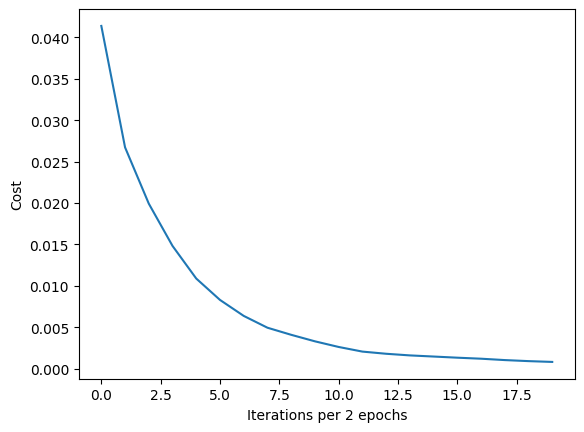

In [210]:
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations per 2 epochs')
plt.show()

In [211]:
correct = 0
incorrect=[]

for i in range(test_y.shape[0]):
    last,_=forward_pass(np.reshape(test_x[:,i],(784,1)),parameters)
    if np.argmax(last) == test_y[i]:
        correct +=1
    else:
        incorrect.append(i)
accuracy = correct/test_y.shape[0]
print("Test Accuracy:",accuracy)

Test Accuracy: 0.9729


In [212]:
import PIL.ImageOps 
def invert_image(test_img):
    I = np.asarray(test_img)
    zero_pixels=0
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i,i] == 0:
                zero_pixels+=1
    non_zero_pixels = 784-zero_pixels
    if non_zero_pixels > zero_pixels:
        inverted_image = PIL.ImageOps.invert(test_img)
        return inverted_image
    else:
        return test_img

Prediction:  5
Input Image: 


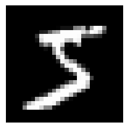

In [214]:
# Try with your own image
from PIL import Image
test_img = Image.open('img.png') #path of the image
test_img_converted = test_img.convert('L')
test_img_resized = test_img_converted.resize((28,28))
test_img_resized = invert_image(test_img_resized) # converts the image having white background to black background
test_img_array = np.asarray(test_img_resized)/255.0

prediction,_=forward_pass(np.reshape(test_img_array,(784,1)),parameters)
predicted_num=np.argmax(prediction)
print("Prediction: ",predicted_num)
print("Input Image: ")
test_img.resize((128,128))